In [ ]:
#export
import numpy as np
import picos
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# default_exp hamiltonian

In [ ]:
#hide
from nbdev.showdoc import show_doc
from nbdev.export import notebook2script
%load_ext autoreload
%autoreload 2

# Hamiltonian

> The hamiltonian class contains all the information defining the physical system.

The Hamiltonian is used to build the semidefinite program (SdP) that is solved to obtain the bounds and costs (reward) for the agents. In this case, we use Hamiltonians, provided that we are bounding the ground state energy. However, this can be any object defining a problem.  

In [ ]:
#export
class Hamiltonian1D:
    
    x = picos.Constant('x', [[0, 1], [1, 0]])
    y = picos.Constant('y', [[0, -1j], [1j, 0]])
    z = picos.Constant('z', [[1, 0], [0, -1]])
    Id = picos.Constant('Id', [[1, 0], [0, 1]])
    
    def __init__(self, N, linear, quadratic):
        self.N = N
        self.linear = linear
        self.quadratic = quadratic
        
    def draw_system(self, figsize=(8,6), cmap=plt.cm.plasma):
        "Conceptual drawing of the system showing interaction strength and on-site field."
        G = nx.Graph()
        G.add_nodes_from([(node,{'w': w}) for node,w in zip(np.arange(self.N),self.linear)])
        G.add_edges_from([(n,n+1,{'w': w}) if n<self.N-1 else (n,0,{'w': w}) for n,w in zip(np.arange(self.N), self.quadratic)])
        plt.figure(figsize=figsize)
        pos = nx.circular_layout(G)
        for (n, d) in G.nodes(data=True):
            nx.draw_networkx_nodes(G, pos=pos, nodelist=[n], node_size=400, node_color=[d['w']/np.max(self.linear)],
                                   cmap=cmap, vmin=0, vmax=1)
        for (u,v,d) in G.edges(data=True):
            nx.draw_networkx_edges(G, pos=pos, edgelist=[(u,v)], width=5, alpha=d['w']/np.max(self.quadratic))
        d = np.array([-0.1, 0])
        label_pos = {k: v+d if v[0]<0 else v-d for k,v in pos.items()}
        nx.draw_networkx_labels(G, pos=label_pos, font_size=25);
        

In the current release we only provide support for 1D problems. The `Hamiltonian1D` class contains the basic infrastructure to build 1D Hamiltonians with up to 2-body interactions. Spin Hamiltonians can be built based on Pauli operators `x`, `y` and `z`, each corresponding to the respective Pauli matrix, and the identity `Id`, which are already defined in terms of the variables that are used to solve the associated SdPs.

All the Hamiltonians must have a `to_sdp` method, which must output a list of tuples of the form `(support, term)` indicating the sites on which each Hamiltonian term is acting. The `support` is a sorted `np.array`, while the `term` is made of `picos.Constant`. Using the pre-defined Pauli operators, the Hamiltonian terms already have the right format. Furthermore, Hamiltonians should have a `model` property that returns a string, e.g. `'xy'`, to provide proper naming to the associated files involved in the optimization process. See the source code of `XYHamiltonian` or `XXHamiltonian` for some examples. 

## Heisenberg XY model

The quantum Heisenberg XY model is given by $$H=\sum_{i} J_{i}((1+\gamma)\sigma_{i}^x \sigma_{i+1}^x + (1-\gamma)\sigma_{i}^y \sigma_{i+1}^y) + \sum_{i}B_{i}\sigma_{i}^z,$$ 
where $J_i$ is the pair-wise antiferromagnetic exchange and $B_i$ is the strength of the on-site magnetic field. The parameter $\gamma$ induces an anisotropic interaction between directions $x$ and $y$. In the case of $\gamma=0$, we have the so-called XX model $$H=\sum_{i} J_{i}(\sigma_{i}^x \sigma_{i+1}^x + \sigma_{i}^y \sigma_{i+1}^y) + \sum_{i}B_{i}\sigma_{i}^z$$

In [ ]:
#export
class XYHamiltonian(Hamiltonian1D):
    def __init__(self, N, linear, quadratic, g):
        super().__init__(N, linear, quadratic)
        self.g = g
        self.model = 'xy'
        
    def to_sdp(self):
        "Returns hamiltonian in terms of SDP variables."
        linear = [(np.array([i]), self.linear[i]*self.z) for i in range(self.N)]
        quadratic = [(np.sort(np.array([i, (i+1)%self.N])), self._2body_interaction(i)) for i in range(self.N)]
        return linear + quadratic
    
    def _2body_interaction(self, i):
        return self.quadratic[i]*((1+self.g)*self.x@self.x + (1-self.g)*self.y@self.y)

In [ ]:
#export
class XXHamiltonian(Hamiltonian1D):
    def __init__(self, N, linear, quadratic):
        super().__init__(N, linear, quadratic)
        self.model = 'xx'
        
    def to_sdp(self):
        "Returns hamiltonian in terms of SDP variables."
        linear = [(np.array([i]), self.linear[i]*self.z) for i in range(self.N)]
        quadratic = [(np.sort(np.array([i, (i+1)%self.N])), self._2body_interaction(i)) for i in range(self.N)]
        return linear + quadratic
    
    def _2body_interaction(self, i):
        return self.quadratic[i]*(self.x@self.x + self.y@self.y)

In the following example we build a 1D Hamiltonian corresponding to the XX model with inhomogeneous interaction and field strengths.

In [ ]:
N = 10
B = np.array([1, 2, 3, 2, 1, 0.5, 4, 5, 7, 3])
J = np.array([0, 1, 3, 0, 5, 0, 4, 2, 0, 1])
H = XXHamiltonian(N, B, J)

In [ ]:
assert (H.linear == B).all()
assert (H.quadratic == J).all()

The `draw_system` method from `Hamiltonian1D` provides an illustrative representation of the physical system at hand associated to the 1D Hamiltonian. The interaction strength is represented by the transparency of the links between nodes and the strength of the linear terms is represented in the node colors.

In [ ]:
show_doc(Hamiltonian1D.draw_system)

<h4 id="Hamiltonian1D.draw_system" class="doc_header"><code>Hamiltonian1D.draw_system</code><a href="__main__.py#L14" class="source_link" style="float:right">[source]</a></h4>

> <code>Hamiltonian1D.draw_system</code>(**`figsize`**=*`(8, 6)`*, **`cmap`**=*`<matplotlib.colors.ListedColormap object at 0x7f62b9f75550>`*)

Conceptual drawing of the system showing interaction strength and on-site field

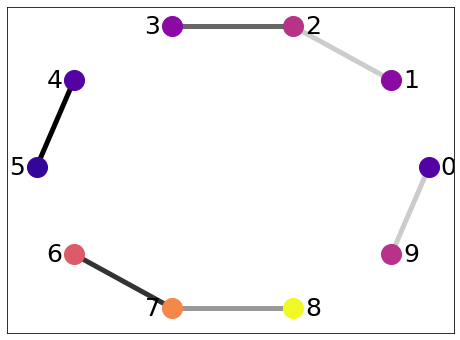

In [ ]:
H.draw_system()

For completeness, we provide an additional example of the Heisenberg Hamiltonian including interaction in the $\sigma^z$ direction $$H=\sum_i J_i(\sigma_{i}^x\sigma_{i+1}^x + \sigma_{i}^y\sigma_{i+1}^y + \sigma_{i}^z\sigma_{i+1}^z) + \sum_i B_i\sigma_i^z$$
This model, with $B_i=0 \ \forall i$, is used in [[1]](https://iopscience.iop.org/article/10.1088/1742-6596/1163/1/012057). See the <a href="https://borjarequena.github.io/BOUNCE/sdp.html">SdP docs</a> for further details.

In [ ]:
#export
class XYZHamiltonian(Hamiltonian1D):
    def __init__(self, N, linear, quadratic):
        super().__init__(N, linear, quadratic)
        self.model = 'xyz'
        
    def to_sdp(self):
        "Returns hamiltonian in terms of SDP variables."
        linear = [(np.array([i]), self.linear[i]*self.z) for i in range(self.N)]
        quadratic = [(np.sort(np.array([i, (i+1)%self.N])), self._2body_interaction(i)) for i in range(self.N)]
        return linear + quadratic
    
    def _2body_interaction(self, i):
        return self.quadratic[i]*(self.x@self.x + self.y@self.y + self.z@self.z)

## References
[1] F. Uskov and O. Lychkovskiy. [A variational lower bound on the ground state of a many-body system and the squaring parametrization of density matrices](https://iopscience.iop.org/article/10.1088/1742-6596/1163/1/012057). *Journal of Physics: Conference Series* **1163** 012057 (2019)

## Export-

In [1]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_environment.ipynb.
Converted 01_agents.ipynb.
Converted 02_budget_profiles.ipynb.
Converted 03_hamiltonian.ipynb.
Converted 04_training.ipynb.
Converted 05_utils.ipynb.
Converted 06_sdp.ipynb.
Converted index.ipynb.
